основная идея - отделять траверсу от остальных частей опоры по пплотности отражений.    

In [238]:
from pathlib import Path
import geopandas as gpd
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from numpy import unique
from numpy import where
from shapely.geometry import Point, MultiPoint, Polygon

In [2]:
p = Path(r'/home/igor/Documents/some_tools/structure_samples/xyz')   # for linux

In [135]:
list_of_files = list(p.glob('*.xyz'))
for file in list_of_files:
    print(file.name)

sus_big.xyz
strain_3_lean_lo.xyz
d-pole_3x.xyz
substation.xyz
sus_5.xyz
st_220_5.xyz
sus_w_wires.xyz
s_pole.xyz
strain_sm.xyz
strain_2.xyz
strain_A_dpole_leaned.xyz
pole-w-guys_near_substation.xyz
sus_2pole_lean.xyz
s_pole_xarms.xyz
pole_asim_post.xyz
strain_A_dpole.xyz
2pole_supp_guys.xyz
pole_asim_3.xyz
st_220_6.xyz
sus_guyed_2x_steel.xyz
sus_220_6.xyz
3pole_guys.xyz
strain_big.xyz


In [213]:
spam_file = p / 'sus_5.xyz'
str = []
with spam_file.open() as f:
        spamreader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC, skipinitialspace=True)
        for row in spamreader:
            str.append(row)
str[:5]

[[1245959.75, 4851979.15, 20.32],
 [1245959.66, 4851979.11, 20.78],
 [1245959.55, 4851979.2, 21.36],
 [1245959.41, 4851979.79, 20.94],
 [1245959.46, 4851979.43, 21.48]]

In [139]:
n_s = np.array(str)
n2 = n_s[:,:2]   # x and y
n2[:5]

array([[1245959.75, 4851979.15],
       [1245959.66, 4851979.11],
       [1245959.55, 4851979.2 ],
       [1245959.41, 4851979.79],
       [1245959.46, 4851979.43]])

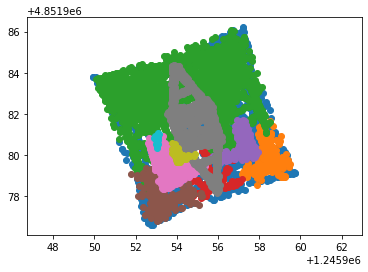

In [154]:
X = n_s
clustering = DBSCAN(eps=1, min_samples=50).fit(X)
#print(clustering.labels_)

yhat = clustering.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.axis('equal')
plt.show()

первая попытка сегментирования в плановом виде без учета высоты.
иногда стабатывает на выделения тела опоры (восновном столбов), но выходит не всегда удачно, особенно на сложных опорах.

далее попробую одномерные графики - плотность по высотной составляющей - должно лучше отделять траверсы (если они без сильного наклона)

In [141]:
n_z = n_s[:,2]   # делаем одномерный массив
n_z[:5]

array([20.32, 20.78, 21.36, 20.94, 21.48])

In [142]:
# двойная разница по высоте в модуле - на столько частей делится выборка - так получается по 0,5м каждая часть
zd = int(abs(n_z.max()- n_z.min())*10)  
zd

292

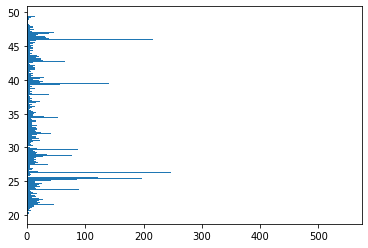

In [143]:
new_a = plt.hist(n_z, zd, orientation='horizontal')

вместо того чтобы пльзоваться гистограмными значениями лучше посчитать сегментацию самому, так будет и проще пользоваться массивом и поиском по нему

In [283]:
# needs to create new segmented list
segmented = []
segment_size = 0.1
start = min(n_z)
end = start + segment_size
while end < max(n_z):
    segmented.append(sum(end > i > start for i in n_z))
    start += segment_size
    end += segment_size

print(len(segmented))

292


In [285]:
# finding h by index:
indx = 15
h = min(n_z) + segment_size*indx

print(indx, segmented[indx], h, h+segment_size)

15 19 21.67 21.770000000000003


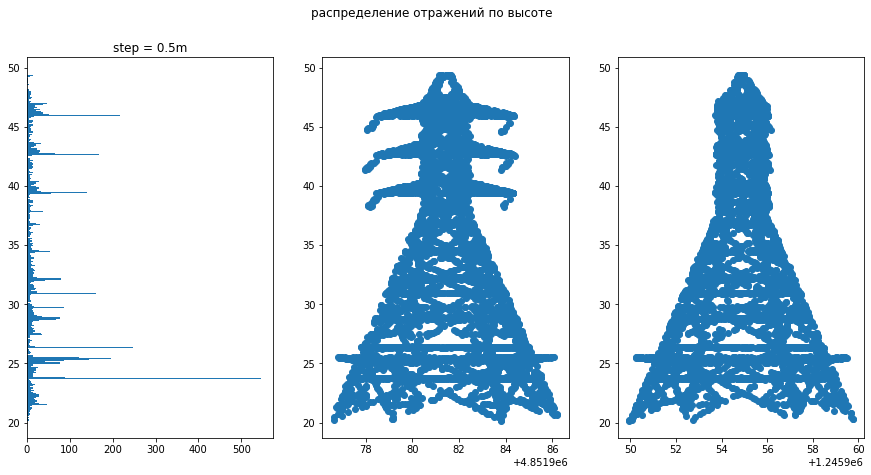

In [144]:
plt.figure(figsize=(15, 7))

plt.subplot(131)  # 1 строка, 3 колонки, 1 колонка
plt.title('step = 0.5m')
plt.hist(n_z, zd, orientation='horizontal')
plt.subplot(132)   # 1 строка, 3 колонки, 2 колонка
plt.plot(n_s[:,1], n_s[:,2], 'o')
plt.subplot(133)
plt.plot(n_s[:,0], n_s[:,2], 'o')

plt.suptitle('распределение отражений по высоте')
plt.show()

как видно на графике по плотности очень хорошо можно находить траверсы, особенно при большом количестве отражений от опоры. На столбах тоже хорошо работает. Дальше нужно будет выделить точки в пиках, и по этим массивам в плане построить прямую (линейную регрессию) которая будет означать угол разворота опоры.  в будущем этот подход позволит также определять нижние кромки траверс.


In [145]:
# при построении графика создался массив new_a[0] 
# каждое значение в new_a[0][х] это количество точек между new_a[1][х] и new_a[1][х+1]

segment = 15
print(f'количество отражений в сегменте №{segment}: {int(new_a[0][segment])} точек')
print(f'дипазон высот этого сегмента: {round(new_a[1][segment], 1)} - {round(new_a[1][segment+1], 1)} m')

количество отражений в сегменте №15: 19 точек
дипазон высот этого сегмента: 21.7 - 21.8 m


In [187]:
np.mean(new_a[0][(len(new_a[0])//2):]), np.mean(new_a[0])

(16.08219178082192, 21.28082191780822)

In [167]:
max_trav = max(new_a[0][(len(new_a[0])//2):])   # max значение выше середины опоры
max_trav

217.0

In [148]:
level = list(new_a[0]).index(max_trav)    # индекс максимального значения
level

257

In [149]:
print(f'самая большая плотность обнаружена в диапазоне: {round(new_a[1][level], 1)} - {round(new_a[1][level+1], 1)}')
print(f'количество точек: {int(max(new_a[0][(len(new_a[0])//2):]))}')

самая большая плотность обнаружена в диапазоне: 45.9 - 46.0
количество точек: 217


In [188]:
# индекс и величина значений больше среднего (выше середины) 

ma = []
for nu, i in enumerate(list(new_a[0])):
    if nu > len(new_a[0])//2:
        if i > (np.mean(new_a[0])//2)*2:
            ma.append((nu, i))
        
for i in ma:
    print(i) 

(165, 31.0)
(166, 22.0)
(176, 38.0)
(191, 56.0)
(192, 140.0)
(193, 32.0)
(194, 23.0)
(195, 27.0)
(196, 28.0)
(197, 21.0)
(200, 22.0)
(201, 29.0)
(224, 168.0)
(225, 66.0)
(226, 28.0)
(227, 30.0)
(228, 24.0)
(229, 24.0)
(233, 32.0)
(257, 217.0)
(258, 51.0)
(259, 37.0)
(260, 32.0)
(261, 22.0)
(262, 31.0)
(264, 23.0)
(266, 37.0)
(267, 46.0)


In [189]:
# break for groups with lowest segment num and sum of points
ma2 = {}
low_level = 0
points_sum = 0

for i in range(len(ma)):
    #print(i, ma[i][0], ma[i][1])
    # если следующий сегмент также отобран
    if i != len(ma)-1 and ma[i][0]+1 == (ma[i+1][0]):
        points_sum += ma[i+1][1]
        
        # если предыдущий сегмент не был отобран 
        if i > 0 and not ma[i][0]-1 == (ma[i-1][0]):
            points_sum += ma[i][1]
            low_level = ma[i][0]
        
        ma2[low_level] = points_sum

    else:
        #print('skip')
        low_level = 0
        points_sum = 0
    
    #print(low_level, points_sum)
ma2

{0: 22.0, 191: 327.0, 200: 51.0, 224: 340.0, 257: 390.0, 266: 83.0}

In [199]:
#  из отобранных групп выделяем три наибольшие
# такой отбор не стаботает на траверсах постоянной высоты - там будет по два выброса на траверсу
selected = sorted(ma2.items(), key=lambda item: item[1])[-3:]
print(selected)

h_trav = []   # нижие кромки траверс
for i in selected:
    h_trav.append(round(new_a[1][i[0]], 1))
z1, z2, z3 = sorted(h_trav)[0], sorted(h_trav)[1], sorted(h_trav)[2]
trav_start = min(h_trav)-0.1  # where xarms start (-0.1 to take a little buff)
print(trav_start, z1, z2, z3)


[(191, 327.0), (224, 340.0), (257, 390.0)]
39.199999999999996 39.3 42.6 45.9


45.9

In [200]:
n_s

array([[1.24595975e+06, 4.85197915e+06, 2.03200000e+01],
       [1.24595966e+06, 4.85197911e+06, 2.07800000e+01],
       [1.24595955e+06, 4.85197920e+06, 2.13600000e+01],
       ...,
       [1.24595385e+06, 4.85198430e+06, 4.59600000e+01],
       [1.24595382e+06, 4.85198414e+06, 4.60600000e+01],
       [1.24595379e+06, 4.85198398e+06, 4.61400000e+01]])

In [201]:
# cut the legs
n_s_cut = np.delete(n_s, n_s[:,2]<trav_start, 0)
n_s_cut 

array([[1.24595596e+06, 4.85197866e+06, 3.94200000e+01],
       [1.24595603e+06, 4.85197899e+06, 3.93900000e+01],
       [1.24595602e+06, 4.85197976e+06, 3.94000000e+01],
       ...,
       [1.24595385e+06, 4.85198430e+06, 4.59600000e+01],
       [1.24595382e+06, 4.85198414e+06, 4.60600000e+01],
       [1.24595379e+06, 4.85198398e+06, 4.61400000e+01]])

In [202]:
n_s_1 = np.delete(n_s_cut, n_s_cut[:,2]>z2, 0)
n_s_3 = np.delete(n_s_cut, n_s_cut[:,2]<z3, 0)

In [203]:
n_s_2 = np.delete(n_s_cut, n_s_cut[:,2]<z2, 0)
n_s_2 = np.delete(n_s_2, n_s_2[:,2]>z3, 0)

In [204]:
X3 = n_s_3[:,0].reshape(-1, 1)
y3 = n_s_3[:,1]

In [205]:
X2 = n_s_2[:,0].reshape(-1, 1)
y2 = n_s_2[:,1]

In [206]:
X1 = n_s_1[:,0].reshape(-1, 1)
y1 = n_s_1[:,1]

In [207]:
X = n_s_cut[:,0].reshape(-1, 1)
y = n_s_cut[:,1]

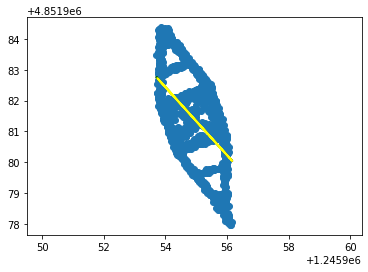

In [209]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
slr1 = LinearRegression()
slr1.fit(X1, y1)
y_pred2 = slr.predict(X1)
slr2 = LinearRegression()
slr2.fit(X2, y2)
y_pred3 = slr.predict(X2)
#print('Slope: {:.2f}'.format(slr.coef_[0]))
#print('Intercept: {:.2f}'.format(slr.intercept_))
plt.scatter(X, y)
plt.axis('equal')
plt.plot(X, slr.predict(X), color='black', linewidth=2)
plt.plot(X1, slr.predict(X1), color='green', linewidth=2)
plt.plot(X2, slr.predict(X2), color='yellow', linewidth=2)

линейная регрессия не особо подходит для определения угла разворота

In [255]:
# will work with xarm 
n_s_1_mp = MultiPoint(n_s_1)    # to multipoint (needs to shapely)
rect1 = n_s_1_mp.minimum_rotated_rectangle
n_s_2_mp = MultiPoint(n_s_2)    # to multipoint (needs to shapely)
rect2 = n_s_2_mp.minimum_rotated_rectangle
n_s_3_mp = MultiPoint(n_s_3)    # to multipoint (needs to shapely)
rect3 = n_s_3_mp.minimum_rotated_rectangle


(1245952.800578403, 1245957.1360695001, 4851977.280025508, 4851985.023875777)

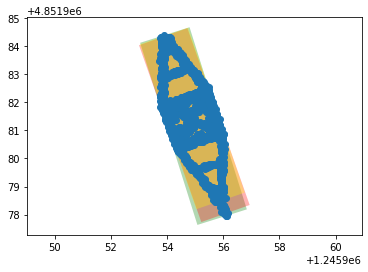

In [256]:
ax = gpd.GeoSeries(rect1).plot(color='green', alpha=0.3)
gpd.GeoSeries(rect2).plot(ax=ax, color='red', alpha=0.3)
gpd.GeoSeries(rect3).plot(ax=ax, color='yellow', alpha=0.3)
plt.scatter(n_s_cut[:,0], n_s_cut[:,1])
plt.axis('equal')


такой метод лучше подходит для определения угла раворота

In [277]:
# определим азимут и расстояние
from math import sqrt, acos, degrees

def azimuth(a, b):
    # by two points we get azimuth
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    dist = sqrt(dx*dx + dy*dy)    # dist a to b
    dx2 = abs(dx)
    beta = degrees(acos(dx2/dist))
    if dx > 0:
        if dy < 0:
            angle = 270 + beta
        else:
            angle = 270 - beta
    else:
        if dy < 0:
            angle = 90 - beta
        else:
            angle = 90 + beta

    return round(angle, 2), dist


In [279]:
# find a longest side
n_s_cut_mp = MultiPoint(n_s_cut)    # to multipoint (needs to shapely)
rect = n_s_cut_mp.minimum_rotated_rectangle

side_a = azimuth(list(rect.exterior.coords)[0], list(rect.exterior.coords)[1])
side_b = azimuth(list(rect.exterior.coords)[1], list(rect.exterior.coords)[2])
if side_a[1] > side_b[1]:
    str_azmt = side_a[0]
else:
    str_azmt = side_b[0]

print(side_a)
print(side_b)
print(str_azmt)

(161.11, 6.8026700607985795)
(71.11, 1.8572203067145663)
161.11
